<a href="https://colab.research.google.com/github/borundev/tensorflow_probability_tutorial/blob/main/Week_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
tfd=tfp.distributions

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

In [3]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
def get_data(categories):
    train_data = fetch_20newsgroups(data_home='20_NewsgroupsData',subset='train',categories=categories)
    test_data = fetch_20newsgroups(data_home='20_NewsgroupsData',subset='test',categories=categories)
    
    n_documents = len(train_data['data'])
    count_vectorizer = CountVectorizer(input='content',binary=True,max_df=.25,min_df =1.01/n_documents)
    
    train_bow = count_vectorizer.fit_transform(train_data['data'])
    test_bow = count_vectorizer.transform(test_data['data'])
    return (train_bow.todense(),train_data['target']),(test_bow.todense(),test_data['target'])

In [5]:
categories = ['alt.atheism', 'talk.religion.misc','comp.graphics','sci.space']

In [6]:
(train_data,train_labels),(test_data,test_labels)=get_data(categories)

In [7]:
train_data.shape

(2034, 17495)

In [8]:
train_labels

array([1, 3, 2, ..., 1, 0, 1])

In [9]:
from collections import Counter
count_dict=Counter(train_labels)
priors=np.array([count_dict[k] for k in range(len(categories))])
priors =priors/ priors.sum()

In [10]:
def laplace_smoothened_mean(labels, binary_data, n_classes):
    '''
    For each word this gives the laplace smoothened mean per class. So for instance in the absence
    of Laplace smoothening the output would be np.stack([train_data[train_labels==i].mean(0) for i in range(n_classes)])
    '''
    n_words = binary_data.shape[1]
    alpha = 1
    theta = []
    for c_k in range(n_classes):
        class_mask = (labels == c_k)
        N = class_mask.sum()
        theta.append((binary_data[class_mask].sum(0) +alpha)/(N+alpha*2))
    return np.stack(theta)


In [11]:
smoothed_means = laplace_smoothened_mean(labels=train_labels,binary_data=train_data,n_classes=len(categories))

In [12]:
def make_dist(probs):
    batch_of_bernoullis = tfd.Bernoulli(probs=probs)
    dist = tfd.Independent(batch_of_bernoullis,reinterpreted_batch_ndims=1)
    return dist

tf_dist = make_dist(smoothed_means)

In [16]:
def predict_sample(dist,sample,priors):
    cond_probs = dist.log_prob(sample)
    joint_likelihood = tf.add(np.log(priors),cond_probs)
    norm_factor = tf.math.reduce_logsumexp(joint_likelihood,axis=-1,keepdims=True)
    log_prob = joint_likelihood - norm_factor
    return log_prob

In [17]:
log_probs = predict_sample(tf_dist,test_data[0],priors)

In [18]:
probabilities = []
for sample,label in zip(test_data,test_labels):
    probabilities.append(tf.exp(predict_sample(tf_dist,sample,priors)))
    
probabilities = np.asarray(probabilities)
predicted_classes = np.argmax(probabilities,axis = -1)
f1_score(test_labels,predicted_classes,average='macro')

0.7848499112849504

In [19]:
clf = BernoulliNB(alpha=1)
clf.fit(train_data,train_labels)
pred = clf.predict(test_data)
f1_score(test_labels,pred,average='macro')

0.7848499112849504

# Trainable Distributions

In [20]:
exponential = tfd.Exponential(rate=.3,name='exp')

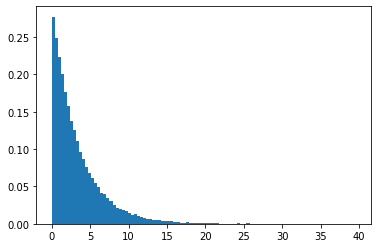

In [21]:
plt.hist(exponential.sample(50000).numpy(), bins=100,density=True);

In [22]:
exp_train = tfd.Exponential(tf.Variable(1.,name='rate'),name='exp_train')

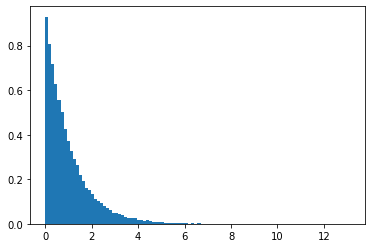

In [23]:
plt.hist(exp_train.sample(50000).numpy(), bins=100,density=True);

In [24]:
exponential.trainable_variables

()

In [25]:
exp_train.trainable_variables

(<tf.Variable 'rate:0' shape=() dtype=float32, numpy=1.0>,)

In [26]:
def nll(x_train,distribution):
    return -tf.reduce_mean(distribution.log_prob(x_train))

In [27]:
#@tf.function
def get_loss_and_grads(x_train,distribution):
    with tf.GradientTape() as tape:
        tape.watch(distribution.trainable_variables)
        loss = nll(x_train,distribution)
        grads = tape.gradient(loss,distribution.trainable_variables)
    return loss, grads

In [28]:
def exponential_dist_optimisation(data, distribution):
    train_loss_results = []
    train_rate_results = []
    optimizer = tf.optimizers.SGD(learning_rate=0.05)
    num_steps = 10
    
    for i in range(num_steps):
        loss, grads = get_loss_and_grads(data,distribution)
        optimizer.apply_gradients(zip(grads,distribution.trainable_variables))
        rate_value = distribution.rate.value()
        
        train_loss_results.append(loss)
        train_rate_results.append(rate_value)
        
    return train_loss_results,train_rate_results

In [29]:
sampled_data = exponential.sample(5000)

In [30]:
train_loss,train_rates = exponential_dist_optimisation(sampled_data,exp_train)

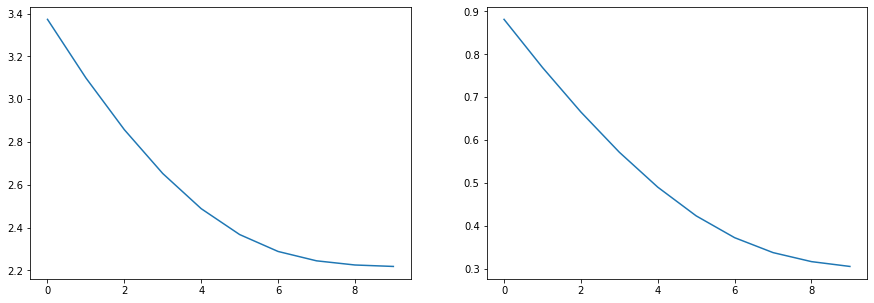

In [31]:
f=plt.figure(figsize=(15,5))
f.add_subplot(1,2,1)
plt.plot(tf.concat(train_loss,0))
f.add_subplot(1,2,2)
plt.plot(tf.concat(train_rates,0))

In [32]:
def make_dist_with_GT(data, labels, nb_classes):
    class_data=[]
    train_vars=[]
    distributions=[]
    for c in range(nb_classes):
        train_vars.append(tf.Variable(initial_value=np.random.uniform(.01,.1,data.shape[-1])))
        distributions.append(tfd.Bernoulli(probs=train_vars[c]))
        class_mask = (labels == c)
        class_data.append(data[class_mask])
    for c in range(nb_classes):
        optimizer = tf.optimizers.Adam()
        for i in range(100):
            if (i+1) % 10 ==0:
                print('Class {}: Step: {}'.format(c,i+1),end='\r')
            loss,grads = get_loss_and_grads(class_data[c],distributions[c])
            optimizer.apply_gradients(zip(grads,distributions[c].trainable_variables))
            eta=1e-3
            clipped_probs = tf.clip_by_value(distributions[c].trainable_variables,eta,1)
            train_vars[c]=tf.squeeze(clipped_probs)
            
    dist = tfd.Bernoulli(probs=train_vars)
    dist = tfd.Independent(dist,reinterpreted_batch_ndims=1)
    print(dist)
    return dist

In [33]:
tf_dist

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[4] event_shape=[17495] dtype=int32>

In [34]:
GT_dist = make_dist_with_GT(data=train_data,labels=train_labels,nb_classes=4)

tfp.distributions.Independent("IndependentBernoulli", batch_shape=[4], event_shape=[17495], dtype=int32)


In [35]:
for dist in [GT_dist,tf_dist]:
    probabilities = []
    for sample,label in zip(test_data,test_labels):
        probabilities.append(predict_sample(dist,sample,priors))
    probabilities = np.array(probabilities)
    predited_classes = np.argmax(probabilities,axis=-1)
    print('f1',f1_score(test_labels,predited_classes,average='macro'))

f1 0.835719715769969
f1 0.7848499112849504
